In [1]:
#%pip install tensorflow

### Data Collection. 
The dataset includes detailed information on resale transactions of HDB flats between January 1, 2017, and March 30, 2024. The dataset contains 180,154 rows and 11 columns and was downloaded on May 23, 2024. 

**Dataset URL**: [HDB Resale Prices](https://beta.data.gov.sg/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/view) 
**HDB RPI URL**:[HDB Resale Prices Index](https://www.hdb.gov.sg/residential/selling-a-flat/overview/resale-statistics)

(180154, 11) (175672, 15) (175672, 52)


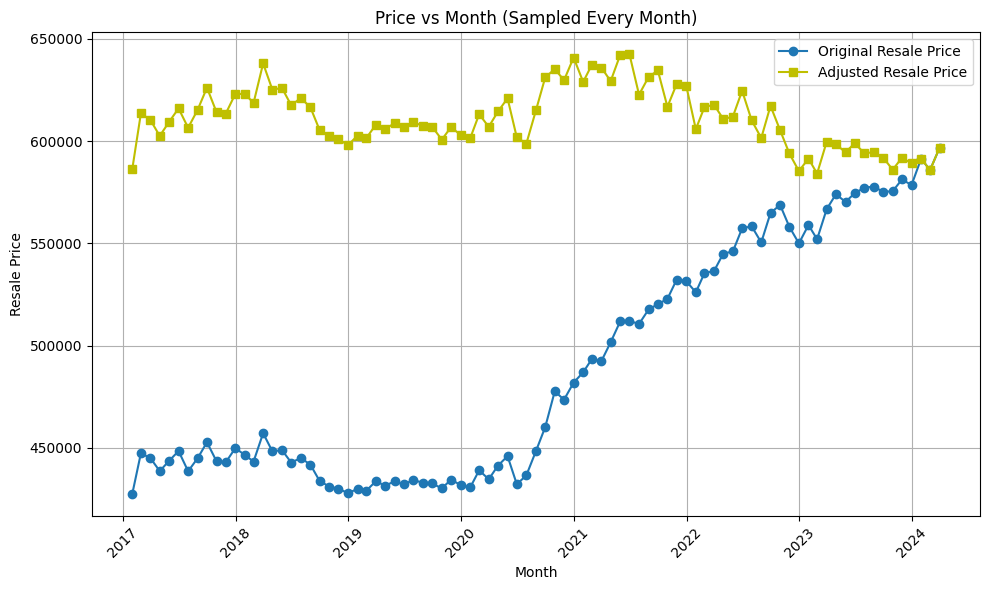

In [2]:
import pandas as pd
import data_config as cfg

df_raw = pd.read_csv('./data/SGHDB2017-2024.csv')
cfg.save_dataset_info(df_raw, fname='dataset_info.csv')

df = cfg.adjust_resale_price(df_raw, cut_off_date='2024-04-01')
cfg.visualize_adjusted_price(df[['month', 'resale_price', 'adjusted_price']].copy(), fname='adjusted_price.png')

df_clean = cfg.preprocess_data(df)
print(df_raw.shape, df.shape, df_clean.shape)
df_clean.to_csv('./data/SGHDB2017-2024_clean.csv', index=False)

Install Required Libraries: 
Ensure you have the necessary libraries installed. You can install them using pip if they are not already installed.
```sgh 
pip install tensorflow pandas scikit-learn
```

### Step 1: 
The project starts by importing the pandas library and loading a cleaned CSV file named {SGHDB2017-2024_clean.csv} into a Pandas DataFrame $df$. Then, the {adjusted_price} column, which represents the housing prices to be predicted, is extracted and stored in the variable $y$ and the remaining columns, which serve as features for the model, are stored in the variable $X$.

In [3]:
# Step 1: Load the data
import pandas as pd
df = pd.read_csv('./data/SGHDB2017-2024_clean.csv')
y = df['adjusted_price'].values   # Target
X = df.drop(columns = 'adjusted_price')  # Features

### Step 2: Prepare the Data:
The dataset is well maintained and prepared by the Singapore government's open data portal. There is no missing data, which simplifies the preprocessing steps. 
Load your dataset and prepare it for training. This includes splitting it into training and testing sets and normalizing the features.

In [4]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Step 2: Prepare the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize continuous features
continuous_columns = ['flat_type', 'floor_area_sqm',  'floor', 'remaining_lease_months']
binary_columns = df.columns.difference(continuous_columns + ['adjusted_price']).tolist()
scaler = StandardScaler()
X_train_continuous = scaler.fit_transform(X_train[continuous_columns])
X_test_continuous = scaler.transform(X_test[continuous_columns])

# Combine scaled continuous features and binary features
X_train = np.hstack([X_train_continuous, X_train[binary_columns].values])
X_test = np.hstack([X_test_continuous, X_test[binary_columns].values])

### Step 3: 
This step defines a function create_regression_model that constructs a feedforward neural network model for regression using TensorFlow's Keras API. 

In [5]:
import tensorflow as tf

def create_regression_model(input_shape, params={}):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=input_shape),    
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

### Step 4: 
The model is trained using the training data  (\(X_{\text{train}}\) and \(y_{\text{train}}\)). The training process runs for 10 epochs (def: \ref{def:epoch}) with a batch size of 32. 

In [6]:
# Step 4: Create and train the model
import time
start_time=time.time()
model = create_regression_model(input_shape=[X_train.shape[1]])
model.summary()
history = model.fit(X_train, y_train, epochs=10, batch_size=32, 
                    validation_data=(X_test, y_test), verbose=0)
end_time = time.time()

# Calculate duration
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,209 (8.63 KB)

 Trainable params: 2,209 (8.63 KB)

 Non-trainable params: 0 (0.00 B)

Training time: 65.73 seconds


### Step 5:
In the last step, the model is evaluated using various performance metrics and saves the evaluation results to a CSV file.

In [7]:
# Step 4: Evaluate the model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

df_results = pd.DataFrame(columns=['Train', 'Test'])

y_pred = model.predict(X_train)
df_results.loc['Root Mean Squared Error', 'Train'] = np.sqrt(mean_squared_error(y_train, y_pred))
df_results.loc['Mean Aboslute Error', 'Train'] = mean_absolute_error(y_train, y_pred)
df_results.loc['Mean Aboslute Percentage Error', 'Train'] = mean_absolute_percentage_error(y_train, y_pred)*100
df_results.loc['R2 score', 'Train'] = r2_score(y_train, y_pred)

y_pred1 = model.predict(X_test)
df_results.loc['Root Mean Squared Error', 'Test'] = np.sqrt(mean_squared_error(y_test, y_pred1))
df_results.loc['Mean Aboslute Error', 'Test'] = mean_absolute_error(y_test, y_pred1)
df_results.loc['Mean Aboslute Percentage Error', 'Test'] = mean_absolute_percentage_error(y_test, y_pred1)*100
df_results.loc['R2 score', 'Test'] = r2_score(y_test, y_pred1)

df_results = df_results.astype('Float64').round(2)
df_results.to_csv('./data/model_evaluation.csv')

3843/3843 ━━━━━━━━━━━━━━━━━━━━ 3s 652us/step
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step


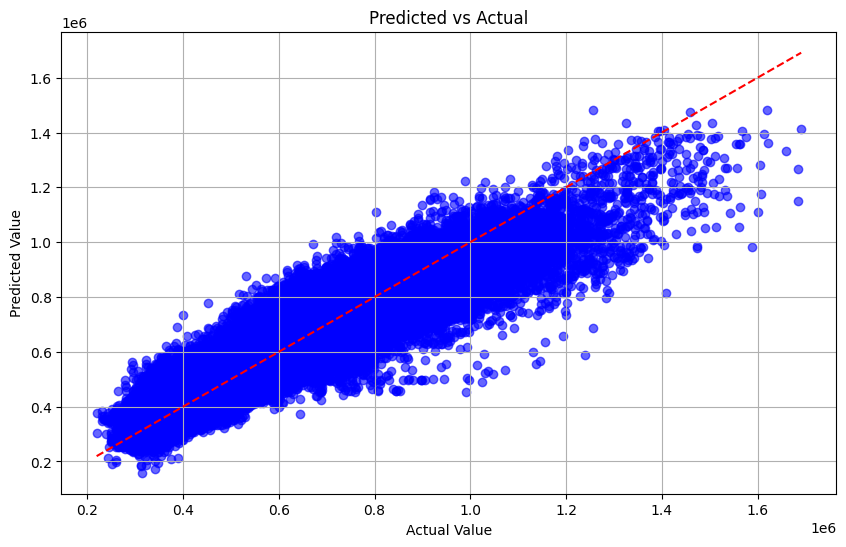

In [8]:
import matplotlib.pyplot as plt

import numpy as np

# Ensure prediction output is in 1D format
y_pred = model.predict(X_test)

# Flatten both arrays to ensure matching shape
y_pred = y_pred.flatten()
y_test = np.array(y_test).flatten()

# Define the plotting function
def plot_predictions(y_actual, y_predicted):
    if len(y_actual) != len(y_predicted):
        print("Error: Length mismatch between actual and predicted values.")
        return
    plt.figure(figsize=(10, 6))
    plt.scatter(y_actual, y_predicted, color='blue', alpha=0.6)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], color='red', linestyle='--')
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    plt.title('Predicted vs Actual')
    plt.grid(True)
    plt.show()

# Call the function to generate the graph
plot_predictions(y_test, y_pred)
